In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
path = ('/content/drive/MyDrive/Data_Science/model/Weather_history_jordan_project/data_weather_jordan/amman_data_For_ML.csv')
df = pd.read_csv(path)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
print(df.head())

            maxtempC  mintempC  avgtempC  totalprecipMM  windspeedKmph  \
date                                                                     
2008-07-01        34        24        28            0.0             12   
2008-07-02        34        23        28            0.0             13   
2008-07-03        34        23        27            0.0             12   
2008-07-04        34        21        27            0.0             13   
2008-07-05        34        23        28            0.0             13   

            sunhour  weatherCode  humidity  visibilityKm  pressureMB  ...  \
date                                                                  ...   
2008-07-01     13.6          113        48            10        1006  ...   
2008-07-02     13.6          113        47            10        1006  ...   
2008-07-03     13.6          113        51            10        1006  ...   
2008-07-04     13.6          113        54            10        1006  ...   
2008-07-05     13.6

In [3]:
df['targ_temp_next_day'] = df['maxtempC'].shift(-1)
df.dropna(inplace=True)
df.head()

,maxtempC,mintempC,avgtempC,totalprecipMM,windspeedKmph,sunhour,weatherCode,humidity,visibilityKm,pressureMB,...,moon_illumination,month,month_sin,month_cos,day,day_sin,day_cos,wind_cos,wind_sin,targ_temp_next_day
date,,,,,,,,,,,,,,,,,,,,,
2008-07-01,34,24,28,0.0,12,13.6,113,48,10,1006,...,89.7,7,-0.5,-0.866025,1,0.201299,0.979530,0.438371,-0.898794,34.0
2008-07-02,34,23,28,0.0,13,13.6,113,47,10,1006,...,82.8,7,-0.5,-0.866025,2,0.394356,0.918958,0.390731,-0.920505,34.0
2008-07-03,34,23,27,0.0,12,13.6,113,51,10,1006,...,75.9,7,-0.5,-0.866025,3,0.571268,0.820763,0.544639,-0.838671,34.0
2008-07-04,34,21,27,0.0,13,13.6,113,54,10,1006,...,69.0,7,-0.5,-0.866025,4,0.724793,0.688967,0.544639,-0.838671,34.0
2008-07-05,34,23,28,0.0,13,13.6,113,46,10,1007,...,62.1,7,-0.5,-0.866025,5,0.848644,0.528964,0.406737,-0.913545,33.0


In [4]:
df.columns

Index(['maxtempC', 'mintempC', 'avgtempC', 'totalprecipMM', 'windspeedKmph',
       'sunhour', 'weatherCode', 'humidity', 'visibilityKm', 'pressureMB',
       'cloudcover', 'DewPointC', 'WindGustKmph', 'sunrise', 'sunset',
       'moon_illumination', 'month', 'month_sin', 'month_cos', 'day',
       'day_sin', 'day_cos', 'wind_cos', 'wind_sin', 'targ_temp_next_day'],
      dtype='object')

In [5]:
features = df.drop([ 'sunrise', 'sunset','targ_temp_next_day'],axis = 1)
target = df[['maxtempC']]

In [6]:
scaler = MinMaxScaler()

features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target).reshape(-1)

In [7]:
def create_dataset(X, y, time_steps=1):
  Xs, ys = [], []
  for i in range(len(X)-time_steps):
    Xs.append(X[i:(i+time_steps)])
    ys.append(y[i+time_steps])
  return np.array(Xs), np.array(ys)

In [8]:
time_steps = 7
X ,y = create_dataset(features_scaled,target_scaled,time_steps)

In [9]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:

model = Sequential([

    LSTM(units = 100,
         return_sequences = True,
         input_shape = (X_train.shape[1],
                        X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(units = 50),
    BatchNormalization(),
    Dropout(0.3),
    Dense(units=1,activation='sigmoid')
])

model.compile(optimizer = 'adam',
              loss = 'mean_absolute_error',
              metrics = ['r2_score','mse']
              )
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 100)         │        49,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 100)         │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,051 (312.70 KB)

 Trainable params: 79,751 (311.53 KB)

 Non-trainable params: 300 (1.17 KB)

In [11]:
Early_stop = EarlyStopping(monitor= 'val_loss',patience=5, restore_best_weights=True)

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Specify a filepath where the model checkpoints will be saved
filepath = 'best_model_weights.weights.h5'  # Example filepath

model_checkpoint_callback = ModelCheckpoint(
    filepath=filepath,  # Add the filepath argument
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [13]:
history = model.fit(X_train,
                    y_train,
                    epochs = 50,
                    batch_size=64,

                    validation_data = (X_test, y_test),
                    callbacks = [Early_stop,model_checkpoint_callback],
)

model.save('amman_model.h5')


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.1956 - mse: 0.0580 - r2_score: -0.5736 - val_loss: 0.1663 - val_mse: 0.0367 - val_r2_score: 0.1830
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1414 - mse: 0.0295 - r2_score: 0.2418 - val_loss: 0.1672 - val_mse: 0.0384 - val_r2_score: 0.1450
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1198 - mse: 0.0223 - r2_score: 0.3947 - val_loss: 0.1531 - val_mse: 0.0317 - val_r2_score: 0.2930
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1067 - mse: 0.0177 - r2_score: 0.5216 - val_loss: 0.1377 - val_mse: 0.0252 - val_r2_score: 0.4379
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0900 - mse: 0.0127 - r2_score: 0.6673 - val_loss: 0.1239 - val_mse: 0.0206 - val_r2_score: 0.5402
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0814 - mse: 0.0105 - r2_score: 0.7191 - val_loss: 0.1041 - val_mse: 0.0154 - val_r2_score: 0.6567
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 21m

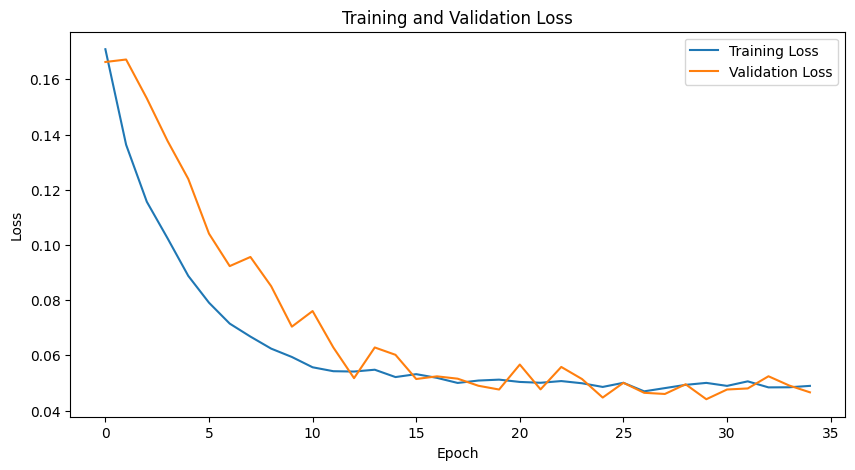

In [14]:
fig= plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


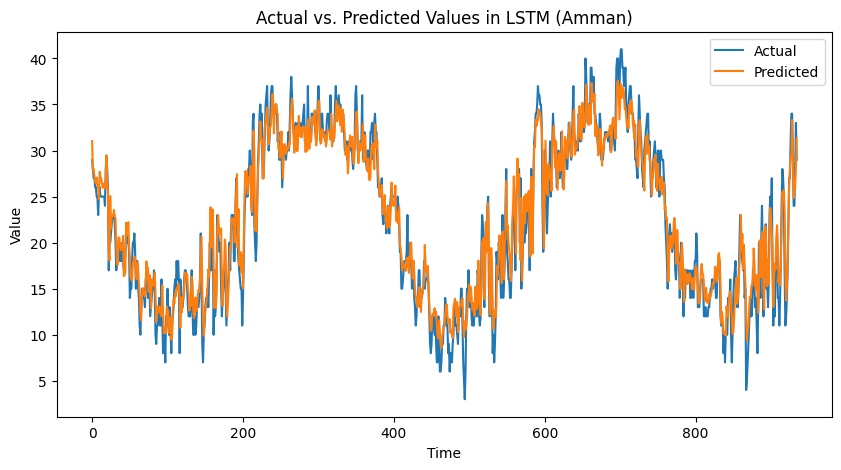

In [15]:
fig= plt.figure(figsize=(10,5))
y_pred = model.predict(X_test)
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual')
plt.plot(scaler.inverse_transform(y_pred), label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values in LSTM (Amman)')
plt.legend()
plt.show()

In [16]:
X_train.shape

(3740, 7, 22)

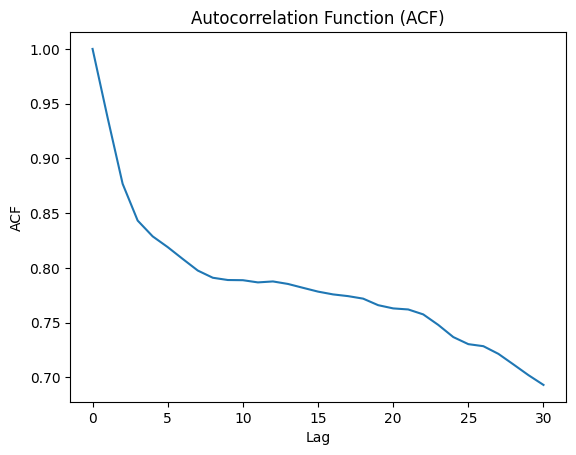

In [17]:
from statsmodels.tsa.stattools import acf
acf_values = acf(y_train, nlags=30)
plt.plot(acf_values)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')
plt.show()

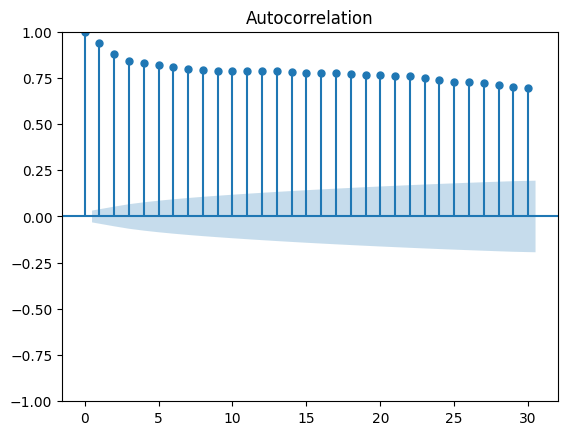

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y_train, lags=30)
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
print("R2 Score:", R2)

R2 Score: 0.9266003333193003
